In [2]:
!pip install yfinance
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 47.0 MB/s eta 0:00:00


กำลังดึงข้อมูล SPY จาก Yahoo Finance...


[*********************100%***********************]  1 of 1 completed



---------------------------------------------------------
Model 1: Standard GARCH(1,1) with Normal Distribution
สมมติฐาน: ข่าวดี/ร้ายส่งผลเท่ากัน และข้อมูลมีการกระจายตัวปกติ
---------------------------------------------------------
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8346.40
Distribution:                  Normal   AIC:                           16700.8
Method:            Maximum Likelihood   BIC:                           16727.6
                                        No. Observations:                 6036
Date:                Mon, Jan 12 2026   Df Residuals:                     6035
Time:                        12:54:36   Df Model:                            1
                                 Mean Model             

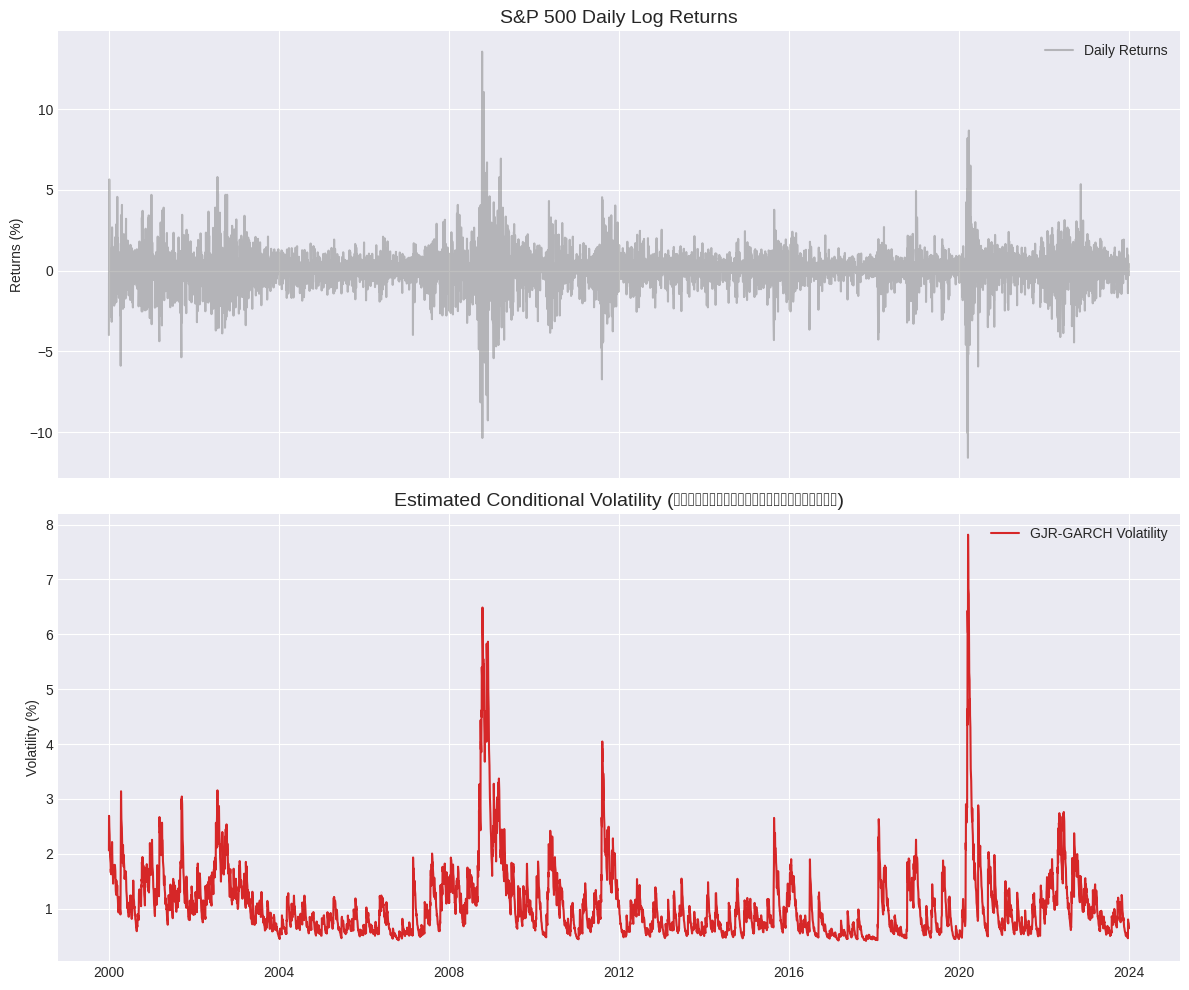

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
from arch import arch_model
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# ปิด Warning เพื่อความสะอาดของ Output
warnings.filterwarnings("ignore")

# ตั้งค่าฟอนต์สำหรับการ plot (รองรับภาษาอังกฤษเป็นหลักเพื่อความเสถียร)
plt.style.use('seaborn-v0_8-darkgrid')

def fetch_data(ticker='SPY', start_date='2000-01-01', end_date='2024-01-01'):
    """
    ดึงข้อมูลราคาหุ้นและคำนวณ Log Returns
    """
    print(f"กำลังดึงข้อมูล {ticker} จาก Yahoo Finance...")
    df = yf.download(ticker, start=start_date, end=end_date)

    # คำนวณ Log Returns
    # หมายเหตุ: การคูณ 100 เพื่อแปลงเป็นเปอร์เซ็นต์ ช่วยให้ Optimizer ของ GARCH ทำงานได้ดีขึ้น (Numerical Stability)
    df['Log_Return'] = 100 * np.log(df['Close'] / df['Close'].shift(1))

    # ตัดข้อมูลแถวแรกที่เป็น NaN ทิ้ง
    df = df.dropna()
    return df['Log_Return']

def run_garch_models(returns):
    """
    สร้างและทดสอบโมเดล GARCH 2 รูปแบบ
    1. Standard GARCH(1,1) - Normal Distribution
    2. GJR-GARCH(1,1) - Skewed t-distribution (ตามบทความที่แนะนำ)
    """

    print("\n---------------------------------------------------------")
    print("Model 1: Standard GARCH(1,1) with Normal Distribution")
    print("สมมติฐาน: ข่าวดี/ร้ายส่งผลเท่ากัน และข้อมูลมีการกระจายตัวปกติ")
    print("---------------------------------------------------------")

    # vol='Garch', p=1 (Lag Variance), q=1 (Lag Residual)
    model_std = arch_model(returns, vol='Garch', p=1, q=1, dist='Normal')
    res_std = model_std.fit(disp='off') # disp='off' เพื่อไม่ให้ print log ระหว่าง fit
    print(res_std.summary())

    print("\n---------------------------------------------------------")
    print("Model 2: GJR-GARCH(1,1) with Skewed t-distribution (Best Fit)")
    print("สมมติฐาน: มี Leverage Effect (ข่าวร้ายแรงกว่า) และข้อมูลเบ้/หางอ้วน")
    print("---------------------------------------------------------")

    # o=1 คือ Asymmetric term (GJR) เพื่อจับ Leverage Effect
    # dist='skewt' คือ Skewed Student's t-distribution
    model_gjr = arch_model(returns, vol='Garch', p=1, o=1, q=1, dist='skewt')
    res_gjr = model_gjr.fit(disp='off')
    print(res_gjr.summary())

    return res_std, res_gjr

def compare_models(res_std, res_gjr):
    """
    เปรียบเทียบค่า AIC และ BIC (ยิ่งต่ำยิ่งดี)
    """
    print("\n=========================================================")
    print("สรุปผลการเปรียบเทียบโมเดล (Model Comparison)")
    print("=========================================================")

    comparison_df = pd.DataFrame({
        'Model': ['Standard GARCH (Normal)', 'GJR-GARCH (Skewed-t)'],
        'AIC': [res_std.aic, res_gjr.aic],
        'BIC': [res_std.bic, res_gjr.bic],
        'Log-Likelihood': [res_std.loglikelihood, res_gjr.loglikelihood]
    })

    print(comparison_df)

    # เช็ค Leverage Effect
    print("\n--- ตรวจสอบ Leverage Effect ใน GJR-GARCH ---")
    gamma = res_gjr.params.get('gamma[1]', 0)
    print(f"ค่า Gamma (Asymmetry Parameter): {gamma:.4f}")
    if gamma > 0:
        print("ผลลัพธ์: พบ Leverage Effect (ค่า Gamma เป็นบวก)")
        print("ความหมาย: ข่าวร้าย (Negative Shocks) ส่งผลให้ความผันผวนเพิ่มขึ้นมากกว่าข่าวดี")
    else:
        print("ผลลัพธ์: ไม่พบ Leverage Effect ที่ชัดเจน")

def plot_results(returns, res_gjr):
    """
    Plot กราฟผลตอบแทนคู่กับความผันผวนที่พยากรณ์ได้
    """
    fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Plot 1: Daily Returns
    ax[0].plot(returns.index, returns, color='grey', alpha=0.5, label='Daily Returns')
    ax[0].set_title('S&P 500 Daily Log Returns', fontsize=14)
    ax[0].set_ylabel('Returns (%)')
    ax[0].legend()

    # Plot 2: Estimated Volatility (Conditional Volatility)
    # Conditional Volatility คือค่าความผันผวนที่โมเดลประเมินได้ในแต่ละวัน
    ax[1].plot(res_gjr.conditional_volatility.index, res_gjr.conditional_volatility,
               color='#d62728', label='GJR-GARCH Volatility')
    ax[1].set_title('Estimated Conditional Volatility (ความผันผวนที่ประเมินได้)', fontsize=14)
    ax[1].set_ylabel('Volatility (%)')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # 1. ดึงข้อมูล
    returns = fetch_data(ticker='SPY', start_date='2000-01-01', end_date='2023-12-31')

    # 2. รันโมเดล
    res_std, res_gjr = run_garch_models(returns)

    # 3. เปรียบเทียบ
    compare_models(res_std, res_gjr)

    # 4. แสดงกราฟ
    plot_results(returns, res_gjr)